# Recurrent Neural Network Video MNIST Lab

By the end of this lab you will have

- Defined and trained a recurrent neural network with keras to perform video frame prediction with `batch_size=1`
- Defined and trained a recurrent neural network with keras to perform video frame prediction with `batch_size=100`
- Evaluated hyperparameters with a validation set
- Defined and trained a recurrent neural network with keras to perform **accurate** video frame prediction

Let's get started!

The mnist video dataset is courtesty of github user [despoisj](https://github.com/despoisj) and his/her [LatentSpaceVisualization]( https://github.com/despoisj/LatentSpaceVisualization) project.

---

# Load Data

The following code loads in the mnist video dataset and displays the first ten samples.

4


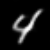

4


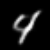

4


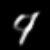

7


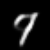

7


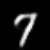

7


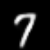

7


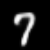

7


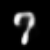

7


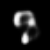

5


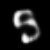

In [1]:
from IPython.display import display
import pickle

[imgs, y] = pickle.load(open('LatentSpaceVisualization/Visuals/mnist_transitions.p', 'rb'))
for img, y_ in zip(imgs[:10], y[:10]):
    print(y_)
    display(img)

# Flatten Images

The following code resizes each image to `(28, 28)` and normalizes the pixel intensities and converts `y` to a categorical representation.

In [2]:
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical

imgs = [img.resize(size=[28, 28]) for img in imgs]
X = np.array([img_to_array(img).flatten() for img in imgs]) / 255.
Y = to_categorical(y)

X.shape, Y.shape

Using TensorFlow backend.


((6000, 784), (6000, 10))

# keras RNNs with `batch_size=1`

## Question

- What shape do you need to convert `X` to to make it compatible a with `SimpleRNN(..., batch_input_shape=[1, 6000, 784])` layer?

## Hints

- This is the most quick-and-dirty way to make `X` and `Y` compatible with a keras recurrent layer

**Solution:** X should be reshaped to (1, 6000, 784)

## Question

- How about `Y`?

## Hint

- The shape for the transformed `Y` is identical to the shape for the transformed `X` but for one dimension

**Solution:** (1,6000,10)

## Task

- Reshape `X` and `Y` and save them into new variables call `X1` and `Y1` respectively which satisfy the above requirement

In [3]:
X1 = X.reshape(1, X.shape[0], X.shape[1])
X1.shape

(1, 6000, 784)

In [4]:
Y1 = Y.reshape(1, Y.shape[0], Y.shape[1])
Y1.shape

(1, 6000, 10)

## Task

- Define a keras RNN model compatible with `X1` and `Y1`

## Requirement

- You must specify

```python
SimpleRNN(..., return_sequences=True, batch_input_shape=[1, 6000, 784])
```

as the first layer in your architecture.

In [5]:
from keras.models import Sequential
from keras.layers import SimpleRNN, TimeDistributed, Dense

batch_size = 1

model = Sequential()
model.add(SimpleRNN(units=10, activation='softmax', return_sequences=True, batch_input_shape=[batch_size, X1.shape[1], X1.shape[2]]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (1, 6000, 10)             7950      
Total params: 7,950.0
Trainable params: 7,950
Non-trainable params: 0.0
_________________________________________________________________


## Task

- Fit your RNN model on `X1` and `Y1`

## Requirement

- Fit your model with `model.fit(..., batch_size=1, shuffle=False, epochs=50)`

In [6]:
X1.shape, Y1.shape, batch_size

((1, 6000, 784), (1, 6000, 10), 1)

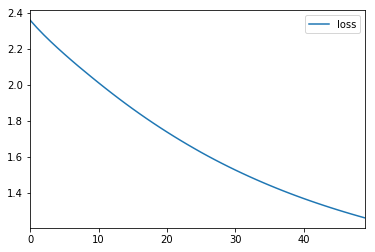

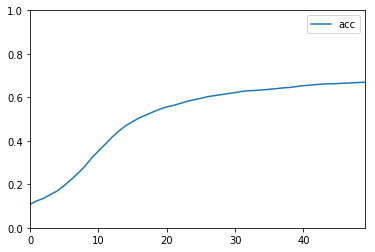

1/1 [==============================] - 3s - loss: 1.2619 - acc: 0.6695


In [7]:
import IPython
import keras
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()
        
model.fit(X1, Y1, batch_size, shuffle=False, epochs=50, callbacks=[TrainingVisualizer()])

## Question

- List two downsides of using `model.fit(..., batch_size=1)` as opposed to `model.fit(..., batch_size=m)` where $m > 1$.

# keras RNNs with `batch_size=100`

## Question

- What shape do you need to convert `X` to to make it compatible a with `SimpleRNN(..., batch_input_shape=[100, 6000, 784])` layer?

## Constraint

- One batch must complete an entire epoch

## Hints

- A batch size of `100` means we effectively have `100` copies of our RNN each of which are being simulaneously unrolled on their respective portions of the original input sequence
- The answer will be of shape `(batch_size, timesteps, 784)`

## Task

- Reshape `X` and `Y` and save them into new variables call `X100` and `Y100` respectively which satisfy the above requirement

## Requirements

- There must be no overlap between batches (i.e. each image can only appear in a single batch

## Hint

- The simplest way to achieve this is to split `X` into `100` different chunks with `numpy.split()`

In [8]:
X.shape, Y.shape

((6000, 784), (6000, 10))

In [9]:
(100, 10, 784)

(100, 10, 784)

In [10]:
batch_size = 100
timesteps = 60

In [11]:
def make_staggered(X_partition, Y_partition, timesteps):
    nb_start = len(Y_partition[0]) // timesteps # number of starts a sequence gets per epoch
    nb_sequence = len(Y_partition) # number of independent sequences
    print(len(X_partition), len(Y_partition), timesteps)
    X = np.zeros([nb_start*nb_sequence, timesteps, 784])
    Y = np.zeros([nb_start*nb_sequence, timesteps, 10])
    print("nb_start:",nb_start,"nb_sequence:",nb_sequence)
    for i, (x, y) in enumerate(zip(X_partition, Y_partition)):
        X[i::nb_sequence] = x.reshape(nb_start, timesteps, 784)
        Y[i::nb_sequence] = y.reshape(nb_start, timesteps, 10)
        
    return X, Y

In [12]:
X_partition, Y_partition = np.split(X, batch_size), np.split(Y, batch_size)
X100, Y100 = make_staggered(X_partition, Y_partition, timesteps)
X100.shape, Y100.shape

100 100 60
nb_start: 1 nb_sequence: 100


((100, 60, 784), (100, 60, 10))

## Task

- Define a RNN model compatible with `X100` and `Y100`

## Requirement

- You must specify

```python
SimpleRNN(..., return_sequences=True, batch_input_shape=[100, 60, 784])
```

as the first layer in your architecture.

In [13]:
model2 = Sequential()
model2.add(SimpleRNN(units=10, activation='softmax', return_sequences=True, batch_input_shape=[batch_size, timesteps, 784]))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (100, 60, 10)             7950      
Total params: 7,950.0
Trainable params: 7,950
Non-trainable params: 0.0
_________________________________________________________________


## Task

- Fit Your RNN Model on `X100` and `Y100`

## Requirement

- Run your model for `model.fit(..., batch_size=100, epochs=50)`

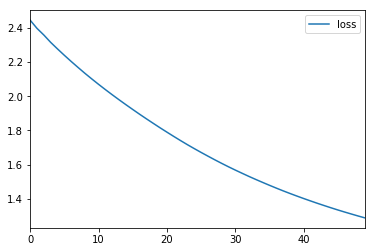

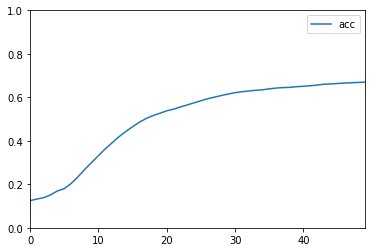

100/100 [==============================] - 0s - loss: 1.2884 - acc: 0.6700


In [14]:
class ResetStates(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()

class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()

model2.fit(X100, Y100, batch_size,
          shuffle=False,
          epochs=50,
          callbacks=[ResetStates(), TrainingVisualizer()]);

## Question

- Describe the differences you see when optimizing on `(X100, Y100)` as opposed to `(X1, Y1)`.

## Task

- Split up `X100` and `Y100` into variables `(X_train50, Y_train50)` and `(X_val50, Y_val50)` and re-fit your model with this validation data

## Hints

- `X_train50` and `Y_train50` have shape `(50, 60, 784)` and `(50, 60, 10)` respectively. Their validation counterparts follow similarly.

In [15]:
X100.shape, Y100.shape

((100, 60, 784), (100, 60, 10))

In [37]:
batch_size = 50
timesteps = 60

In [38]:
X_train50 = X100[:50]
Y_train50 = Y100[:50]
X_val50 = X100[50:]
Y_val50 = Y100[50:]
X_train50.shape, Y_train50.shape, X_val50.shape, Y_val50.shape

((50, 60, 784), (50, 60, 10), (50, 60, 784), (50, 60, 10))

## Task

- Modify your keras model to make it compatible with `(X_train50, Y_train50)` and `(X_val50, Y_val50)`

## Hint

- Re-instantiate your model with `SimpleRNN(..., batch_input_shape=[50, 60, 784])`

In [39]:
model3 = Sequential()
model3.add(SimpleRNN(units=10, activation='softmax', return_sequences=True, batch_input_shape=[batch_size, timesteps, 784]))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (50, 60, 10)              7950      
Total params: 7,950.0
Trainable params: 7,950
Non-trainable params: 0.0
_________________________________________________________________


## Question

- Why did we choose `50` for our new batch size?

**Solution:** Smaller batches could be 

## Task

- Refit your model with `(X_train50, Y_train50)` and `(X_val50, Y_val50)`

## Hint

- Make sure to call `model.fit(..., batch_size=50)`

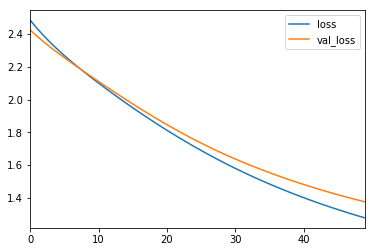

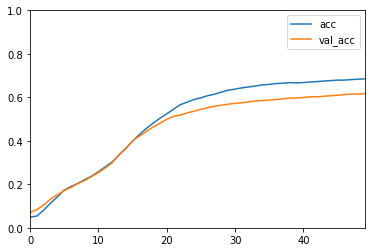

50/50 [==============================] - 0s - loss: 1.2779 - acc: 0.6850 - val_loss: 1.3760 - val_acc: 0.6170


In [40]:
model3.fit(X_train50, Y_train50, batch_size,
          validation_data=(X_val50, Y_val50),
          shuffle=False,
          epochs=50,
          callbacks=[ResetStates(), TrainingVisualizer()]);

## Task

- Design and optimize a recurrent neural network to maximize validation accuracy on `(X_val50, Y_val50)`

## Hints

- Stack multiple recurrent layers
- Use a convolutional layer between the recurrent layers and the image

## Requirement

- The only recurrent layer you can use is SimpleRNN

In [73]:
X_train50.shape, batch_size, timesteps

((50, 60, 784), 50, 60)

In [87]:
from keras.layers import Dense, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D

In [99]:
model4 = Sequential()
model4.add(SimpleRNN(units=10, activation='softmax', return_sequences=True, batch_input_shape=[batch_size, timesteps, 784]))
model4.add(Conv1D(10, 
                 kernel_size=1,
                 activation='softmax'))
model4.add(MaxPooling1D(pool_size=1))
model.add(Dense(10, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_24 (SimpleRNN)    (50, 60, 10)              7950      
_________________________________________________________________
conv1d_25 (Conv1D)           (50, 60, 10)              110       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (50, 60, 10)              0         
Total params: 8,060.0
Trainable params: 8,060.0
Non-trainable params: 0.0
_________________________________________________________________


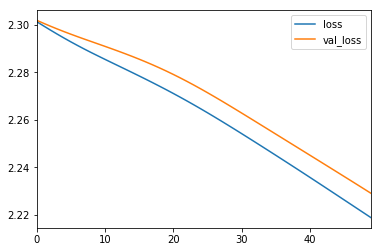

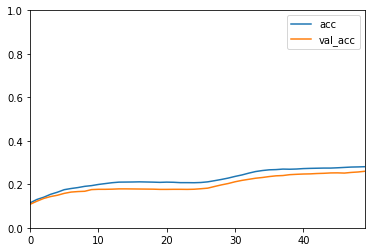

50/50 [==============================] - 0s - loss: 2.2187 - acc: 0.2810 - val_loss: 2.2290 - val_acc: 0.2600


In [72]:
model4.fit(X_train50, Y_train50, batch_size,
          validation_data=(X_val50, Y_val50),
          shuffle=False,
          epochs=50,
          callbacks=[ResetStates(), TrainingVisualizer()]);

# Bonus Activities

- Use more than one batch per epoch with keras stateful RNNs
- Use overlapping windows instead of disjoint windows in each batch
- Monitor gradients during training with tensorboard